In [2]:
from obspy import UTCDateTime
import obspy
import obspy.io.sac.sactrace
from obspy.taup import TauPyModel
from obspy import read_inventory
from obspy.clients.iris import Client
client = Client()
import os
import glob

In [3]:
def theo_arrival(data_dir, model_name, phase):
    """
    Write theoretical arrival times of P waves
    """
    model = TauPyModel(model=model_name)

    for ev in os.listdir(data_dir):
        print(ev)
        inpath = os.path.join(data_dir, ev)

        for sacfile in glob.glob('{}/*.SAC'.format(inpath)):

            st = obspy.read(sacfile)
            sachd = st[0].stats.sac
            
            # set P-wave first arrival
            distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
            gcarc = distaz['distance']
            arrivals = model.get_travel_times(source_depth_in_km=sachd["evdp"],
                                  distance_in_degree=gcarc, phase_list=[phase])
            
            sachd["t1"] = arrivals[0].time + sachd["o"]
            sachd["kt1"] = arrivals[0].name
            
            st[0].write(sacfile, format="SAC")

In [4]:
def read_evt(evtf):
    """
    read event information
    """
    with open(evtf, 'r') as f:
        lines = f.readlines()[1:]
        events = []
        dnames = []
        enum = 0
        for line in lines:
            enum += 1
            if (enum<=20):
                print("No:{}  evt:{}".format(enum,line))
                line = line.strip()
                temp = line.split(',')
                t = UTCDateTime(temp[0])
                lat, lon = float(temp[1]), float(temp[2])
                depth = float(temp[3])
                dpu = temp[4]
                mag = float(temp[5])
                magt = temp[6]
                events.append([t, lat, lon, depth, dpu, mag, magt])
                dnames.append("".join(temp[0].split("T")[0].split("-")) + "".join("".join("".join(temp[0].split("T")[1].split("Z")).split(".")).split(":")))
        return dnames, events

In [5]:

def mseed2sac(data_root, data_out, data_staxml, dnames, events):
    """
    convert miniseed to SAC
    """
    for evt in zip(dnames, events):
        outd = os.path.join(data_out, evt[0])
        if not os.path.exists(outd):
            os.makedirs(outd)

            fpath = os.path.join(data_root, evt[0], '*.mseed')
            try:
                st = obspy.read(fpath)
            except FileNotFoundError:
                print("Missing File: %s" % fpath)
                continue
    
            for tr in st:
                outfile = "{}.{}".format(tr.stats.network,tr.stats.station)
              #  print(outfile)
           
            # get the staxml
                stas = read_inventory(f"{data_staxml}/{outfile}.xml")
                
            # remove the response
                trace = tr.copy()
                inv = read_inventory()
                trace.remove_response(inventory=stas) 
            # convert to SACTrace from ObsPy Trace
                sactr = obspy.io.sac.SACTrace.from_obspy_trace(trace)
            
            # set event origin time as SAC reference time
                sactr.reftime = evt[1][0]
                sactr.o = 0
                sactr.iztype = 'io'

            # set station location
                sactr.stla = stas[0][0].latitude
                sactr.stlo = stas[0][0].longitude
                sactr.stel = stas[0][0].elevation
            
            # set event location and magnitude
                sactr.evla = evt[1][1]
                sactr.evlo = evt[1][2]
                sactr.evdp = evt[1][3]
                sactr.mag = evt[1][5]
            
            # set cmpaz and cmpinc
                sactr.cmpaz = stas[0][0][0].azimuth
                sactr.cmpinc = stas[0][0][0].dip + 90
            
            # other SAC headers
                sactr.lcalda = 1  # DIST AZ BAZ and GCARC headers will be calculated from station and event coordinates.
                              # Note that thing may not be same if we use ObsPy Trace.
            
            # write to sac files
                sactr.write(os.path.join(outd, tr.id+'.SAC'))

In [6]:
# dirs and files
datadir = '/home/tianjue/SPMS/NCA/Data'
data_mseed = f'{datadir}/Download/miniseed'    
data_staxml = f'{datadir}/Download/stations'
data_sac = f'{datadir}/Download/SAC'                      
evt_lst = f'{datadir}/events.csv'                                     

if not os.path.exists(data_sac):
    os.makedirs(data_sac)
    
# read event metadata
dnames, events = read_evt(evt_lst)

# convert miniseed to sac
mseed2sac(data_mseed, data_sac, data_staxml, dnames, events)

No:1  evt:2020-12-30T08:30:22.090Z, 36.60500, -121.20883,   5.98, KILOMETER,   3.1, Ml

No:2  evt:2020-12-27T19:05:47.530Z, 36.84417, -121.57483,   3.98, KILOMETER,  3.19, Ml

No:3  evt:2020-12-27T04:05:37.150Z, 35.49100, -118.29034,   7.84, KILOMETER,   3.6, Ml

No:4  evt:2020-12-04T03:18:25.150Z, 36.74167, -121.45117,   7.58, KILOMETER,  3.17, Ml

No:5  evt:2020-11-11T20:26:59.420Z, 36.80550, -121.53600,   6.90, KILOMETER,   3.3, Ml

No:6  evt:2020-10-27T19:22:43.900Z, 36.60150, -121.05767,  12.69, KILOMETER,  3.29, Mw

No:7  evt:2020-10-22T06:10:14.890Z, 35.49983, -118.39883,   6.51, KILOMETER,  3.36, Ml

No:8  evt:2020-10-14T21:42:41.170Z, 36.02633, -121.54433,   8.71, KILOMETER,  3.47, Ml

No:9  evt:2020-09-29T02:22:20.750Z, 36.70050, -121.33750,   4.93, KILOMETER,  3.23, Ml

No:10  evt:2020-09-19T06:38:46.860Z, 34.00317, -118.08517,  15.42, KILOMETER,  4.56, Mw

No:11  evt:2020-09-06T01:48:36.730Z, 34.57367, -120.04150,  11.09, KILOMETER,  3.94, Ml

No:12  evt:2020-08-21T04:33:05

In [7]:
# write theoretical arrival times
theo_arrival(data_sac, "iasp91", "ttp")

20200713011828080
20200626185507950
20200821043305570
20201014214241170
20201111202659420
20201027192243900
20200730134819160
20201204031825150
20200722045709030
20200720220153310
20201227040537150
20200919063846860
20200906014836730
20200725023646680
20201227190547530
20201230083022090
20201022061014890
20200929022220750
20200730112928990
20200730032301850


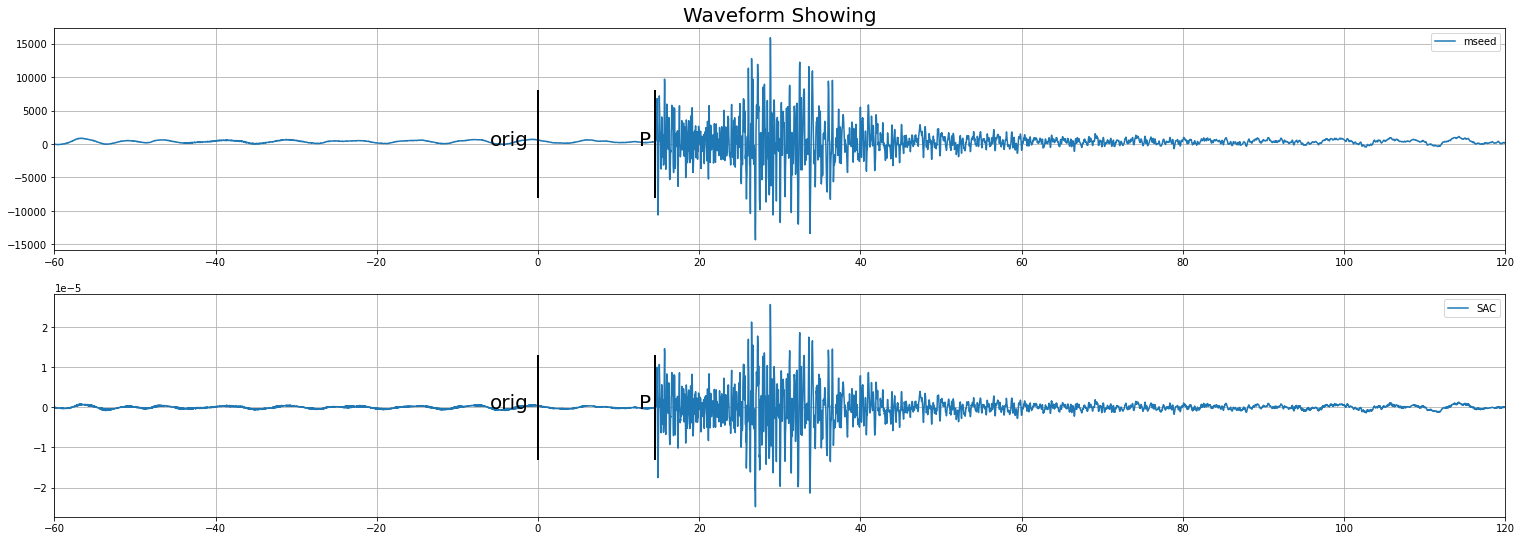

In [67]:
# Quick waveform check
from obspy import read
from obspy.io.sac import SACTrace 
import matplotlib.pyplot as plt
import numpy as np

wtdir="/home/tianjue/SPMS/NCA/Data/Download"
evt = 20201227040537150
st = read(f"{wtdir}/miniseed/{evt}/CI.CCC..BHZ.mseed")

st2 = read(f"{wtdir}/SAC/{evt}/CI.CCC..BHZ.SAC")

d1 = st[0].data
d1 -= d1[0]

d2 = st2[0].data
d2 -= d2[0]

sac = SACTrace.read(f"{wtdir}/SAC/{evt}/CI.CCC..BHZ.SAC")

t = np.arange(0+sac.b, st[0].stats.npts / st[0].stats.sampling_rate+sac.b, st[0].stats.delta)
t2 = np.arange(0+sac.b, st2[0].stats.npts / st2[0].stats.sampling_rate+sac.b, st2[0].stats.delta)

plt.figure(figsize=(26,9))
plt.subplot(211)
plt.plot(t,d1,label="mseed")
#origin time
plt.plot([sac.o, sac.o], [-1*max(d1)*0.5, max(d1)*0.5], color="black", linewidth=2)
plt.text(sac.o-6, -1*max(d1)*0.01, 'orig', fontsize=20)
#first-P arrival
plt.plot([sac.t1, sac.t1], [-1*max(d1)*0.5, max(d1)*0.5], color="black", linewidth=2)
plt.text(sac.t1-2, -1*max(d1)*0.01, 'P', fontsize=20)
plt.xlim(-60, 120)
plt.legend()
plt.title('Waveform Showing', fontsize=20)
plt.grid()

plt.subplot(212)
plt.plot(t,d2,label="SAC")
#origin time
plt.plot([sac.o, sac.o], [-1*max(d2)*0.5, max(d2)*0.5], color="black", linewidth=2)
plt.text(sac.o-6, -1*max(d2)*0.01, 'orig', fontsize=20)
#first-P arrival
plt.plot([sac.t1, sac.t1], [-1*max(d2)*0.5, max(d2)*0.5], color="black", linewidth=2)
plt.text(sac.t1-2, -1*max(d2)*0.01, 'P', fontsize=20)
plt.xlim(-60, 120)
plt.legend()
plt.grid()

plt.show()